In [1]:
%pip install git+https://github.com/mjkvaak/ImageDataAugmentor
%pip install git+https://www.github.com/keras-team/keras-contrib.git
%pip install efficientnet

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-meklcdns
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-meklcdns
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=be4248d5f4cb6c22030d02b68bbc8abf4977f39fcae41096d79d39ab0b5d2883
  Stored in directory: /tmp/pip-ephem-wheel-cache-_8pg95s8/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
Note: you may need to restart the kernel to use updated packages.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-5_xizqtw
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-5_xizqtw
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101064 sha256=a54a8f79f9a86e55df381333e5a7c0dfaf8c2700fae327e603b5363d78a8d8bf
  Stored in directory: /tmp/pip-eph

In [2]:
import matplotlib.pyplot as plt


def plot_model_progress(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(len(acc))
    
    plt.figure(figsize=[6.4*2, 4.8*1.2], constrained_layout=False)
    plt.subplot(1, 2, 1)

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

In [3]:
from dataclasses import dataclass
from pathlib import Path


@dataclass
class Options:
    seed: int
    batch_size: int
    validation_split: float
    
    classes_num: int
    img_shape: 'typing.Tuple[int]'
    
    input_dir: Path = Path('/kaggle/input/sf-dl-car-classification/')
    working_dir: Path = Path('/kaggle/working/')
    
    @property
    def samples_dir(self):
        return self.working_dir / 'samples'
    
    @property
    def models_dir(self):
        return self.working_dir / 'models'

# Настройки

In [4]:
options = Options(
    seed=46,
    batch_size=32,
    validation_split=0.15,
    classes_num=10,
#     img_shape=(224, 224, 3),
    img_shape=(380, 380, 3),
)

options.samples_dir.mkdir(parents=True, exist_ok=True)
options.models_dir.mkdir(parents=True, exist_ok=True)

# Данные обучающей выборки

In [5]:
import pandas as pd


labels = pd.read_csv(options.input_dir / 'train.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


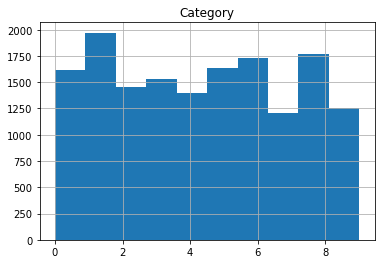

In [6]:
labels.hist(column='Category', bins=options.classes_num);

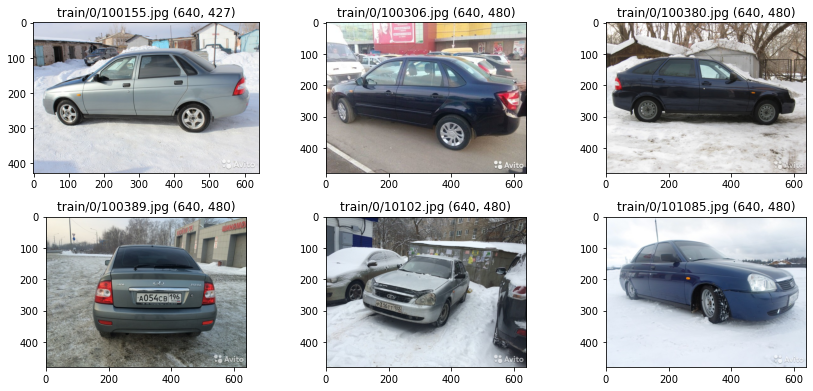

In [7]:
from zipfile import ZipFile
from PIL import Image


plt.figure(figsize=(12,8), tight_layout=True)

max_img_num = 6
index = 0

with ZipFile(options.input_dir / 'train.zip') as zf:
    for entry in zf.infolist():
        if entry.is_dir():
            continue
            
        with zf.open(entry) as file:
            img = Image.open(file)
            plt.subplot(3, 3, index+1)
            plt.imshow(img)
            plt.title('{} {}'.format(entry.filename, img.size))
        
        index += 1
        if index >= max_img_num:
            break

plt.show()

In [8]:
import os


for filename in ('train.zip', 'test.zip'):
    with ZipFile(options.input_dir / filename) as zf:
        zf.extractall(options.samples_dir)

os.listdir(options.samples_dir)

['train', 'test_upload']

# Входные данные

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from ImageDataAugmentor import ImageDataAugmentor
import albumentations


augmentations = albumentations.Compose([
    albumentations.RandomGamma(),
    albumentations.MotionBlur(blur_limit=(3, 5)),
    albumentations.HorizontalFlip(),
    albumentations.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=5),
    albumentations.Downscale(scale_min=0.8, scale_max=0.99),
])

train_imgdatagen = ImageDataAugmentor(
    augment=augmentations,
    rescale=1/255,
    validation_split=options.validation_split,
    seed=options.seed,
)

In [10]:
train_flow = train_imgdatagen.flow_from_directory(
    options.working_dir / 'samples/train/',
    target_size=options.img_shape[:2],
    batch_size=options.batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
)

test_flow = train_imgdatagen.flow_from_directory(
    options.working_dir / 'samples/train/',
    target_size=options.img_shape[:2],
    batch_size=options.batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation',
)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


# Базовая модель для переноса обучения

In [11]:
from keras.callbacks import ModelCheckpoint
from keras_contrib.callbacks import CyclicLR


def checkpoint(filepath):
    return ModelCheckpoint(
        filepath,
        monitor='val_accuracy',
        save_weights_only=True,
        save_best_only=True,
        mode='max',
        verbose=0,
    )

def cyclic_lr(learning_rate, lr_factor, step_size):
    return CyclicLR(
        base_lr=learning_rate,
        max_lr=learning_rate*lr_factor,
        step_size=step_size,
    )

In [12]:
from keras.optimizers import Adam


def fit(model, learning_rate, epochs, train_flow, test_flow, best_model_weights_path):
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy'],
    )

    result = model.fit(
        train_flow,
        steps_per_epoch=len(train_flow),
        validation_data=test_flow,
        validation_steps=len(test_flow),
        epochs=epochs,
        callbacks=[
            cyclic_lr(learning_rate, 10, len(train_flow)*2),
            checkpoint(best_model_weights_path),
        ],
    )

    model.load_weights(best_model_weights_path)
    
    print('Validation')
    scores = model.evaluate(test_flow, verbose=1)
    print('Progress so far {:.2f}%'.format(scores[1] * 100))
    
    plot_model_progress(result.history)

In [13]:
import efficientnet.keras as efn


base_model = efn.EfficientNetB4(
    include_top=False,
    input_shape=options.img_shape,
)

base_model.trainable = False

71892992/71892840 [==============================] - 1s 0us/step


In [14]:
from keras import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization


inputs = Input(shape=options.img_shape)
inters = base_model(inputs, training=False)
inters = GlobalAveragePooling2D()(inters)
inters = Dense(512, use_bias=False, activation='relu')(inters)
inters = BatchNormalization()(inters)
inters = Dropout(0.5)(inters)
outputs = Dense(options.classes_num, activation='softmax')(inters)
model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
efficientnet-b4 (Functional) (None, 12, 12, 1792)      17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               917504    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130  

Epoch 1/20
414/414 [==============================] - 213s 484ms/step - loss: 1.8687 - accuracy: 0.4325 - val_loss: 0.8348 - val_accuracy: 0.6969
Epoch 2/20
414/414 [==============================] - 195s 471ms/step - loss: 0.9091 - accuracy: 0.6913 - val_loss: 0.8005 - val_accuracy: 0.7265
Epoch 3/20
414/414 [==============================] - 193s 465ms/step - loss: 0.7439 - accuracy: 0.7396 - val_loss: 0.7106 - val_accuracy: 0.7497
Epoch 4/20
414/414 [==============================] - 192s 463ms/step - loss: 0.5869 - accuracy: 0.7925 - val_loss: 0.5257 - val_accuracy: 0.8188
Epoch 5/20
414/414 [==============================] - 193s 465ms/step - loss: 0.5126 - accuracy: 0.8195 - val_loss: 0.6010 - val_accuracy: 0.7900
Epoch 6/20
414/414 [==============================] - 192s 464ms/step - loss: 0.5496 - accuracy: 0.8046 - val_loss: 0.6988 - val_accuracy: 0.7548
Epoch 7/20
414/414 [==============================] - 192s 463ms/step - loss: 0.5704 - accuracy: 0.7954 - val_loss: 0.5606 -

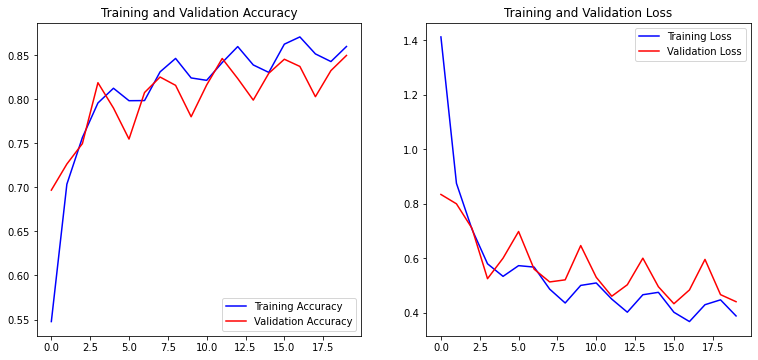

In [15]:
base_model_weights_path = options.models_dir / 'base_model.hdf5'

fit(
    model=model,
    learning_rate=0.0001,
    epochs=20,
    train_flow=train_flow,
    test_flow=test_flow,
    best_model_weights_path=base_model_weights_path,
)

# Тонкая настройка

In [16]:
base_model.trainable = True
for layer in base_model.layers:
    layer.trainable = False

Epoch 1/10
414/414 [==============================] - 321s 742ms/step - loss: 0.3249 - accuracy: 0.8797 - val_loss: 0.3625 - val_accuracy: 0.8729
Epoch 2/10
414/414 [==============================] - 304s 735ms/step - loss: 0.2631 - accuracy: 0.9078 - val_loss: 0.3167 - val_accuracy: 0.8948
Epoch 3/10
414/414 [==============================] - 305s 735ms/step - loss: 0.1985 - accuracy: 0.9322 - val_loss: 0.2746 - val_accuracy: 0.9030
Epoch 4/10
414/414 [==============================] - 306s 738ms/step - loss: 0.1549 - accuracy: 0.9473 - val_loss: 0.2440 - val_accuracy: 0.9210
Epoch 5/10
414/414 [==============================] - 307s 740ms/step - loss: 0.1436 - accuracy: 0.9520 - val_loss: 0.2455 - val_accuracy: 0.9236
Epoch 6/10
414/414 [==============================] - 306s 739ms/step - loss: 0.1379 - accuracy: 0.9520 - val_loss: 0.2390 - val_accuracy: 0.9219
Epoch 7/10
414/414 [==============================] - 305s 737ms/step - loss: 0.1167 - accuracy: 0.9596 - val_loss: 0.2114 -

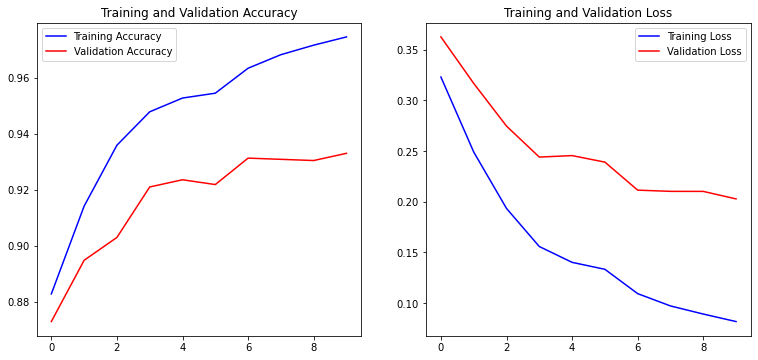

In [17]:
for layer in base_model.layers[113:]:
    layer.trainable = True

tuned_model_weights_path = options.models_dir / 'tuned_model_step_1.hdf5'

fit(
    model=model,
    learning_rate=0.000001,
    epochs=10,
    train_flow=train_flow,
    test_flow=test_flow,
    best_model_weights_path=tuned_model_weights_path,
)

Epoch 1/10
827/827 [==============================] - 697s 823ms/step - loss: 0.0897 - accuracy: 0.9698 - val_loss: 0.2007 - val_accuracy: 0.9330
Epoch 2/10
827/827 [==============================] - 675s 816ms/step - loss: 0.0834 - accuracy: 0.9739 - val_loss: 0.1855 - val_accuracy: 0.9412
Epoch 3/10
827/827 [==============================] - 688s 832ms/step - loss: 0.0693 - accuracy: 0.9777 - val_loss: 0.1802 - val_accuracy: 0.9455
Epoch 4/10
827/827 [==============================] - 675s 816ms/step - loss: 0.0574 - accuracy: 0.9828 - val_loss: 0.1769 - val_accuracy: 0.9438
Epoch 5/10
827/827 [==============================] - 670s 810ms/step - loss: 0.0491 - accuracy: 0.9856 - val_loss: 0.1772 - val_accuracy: 0.9519
Epoch 6/10
827/827 [==============================] - 677s 818ms/step - loss: 0.0508 - accuracy: 0.9852 - val_loss: 0.1700 - val_accuracy: 0.9455
Epoch 7/10
827/827 [==============================] - 687s 831ms/step - loss: 0.0415 - accuracy: 0.9879 - val_loss: 0.1707 -

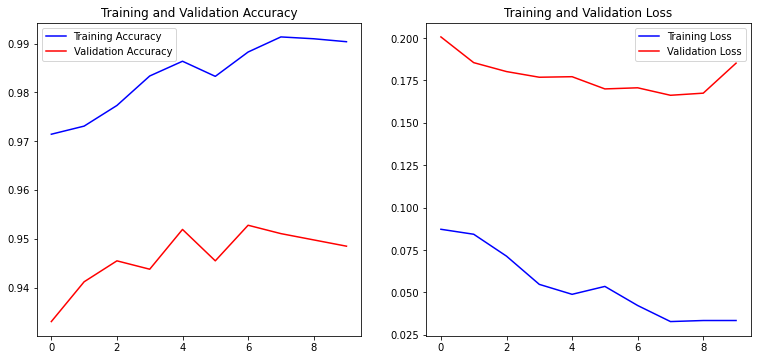

In [25]:
for layer in base_model.layers:
    layer.trainable = True

tuned_model_weights_path = options.models_dir / 'tuned_model_step_2.hdf5'

train_flow.batch_size = 16
test_flow.batch_size = 16

fit(
    model=model,
    learning_rate=0.000001,
    epochs=10,
    train_flow=train_flow,
    test_flow=test_flow,
    best_model_weights_path=tuned_model_weights_path,
)

# Валидация

In [30]:
sample_submission = pd.read_csv(options.input_dir / 'sample-submission.csv')

test_imgdatagen = ImageDataAugmentor(
    augment=augmentations,
    rescale=1/255,
    seed=options.seed,
)

sub_flow = test_imgdatagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=options.samples_dir / 'test_upload/',
    x_col='Id',
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=options.img_shape[:2],
    batch_size=options.batch_size,
)

Found 6675 validated image filenames.


In [32]:
steps = 10
predictions = [model.predict(sub_flow, steps=len(sub_flow), verbose=1) for _ in range(steps)]

209/209 [==============================] - 94s 448ms/step


In [33]:
import numpy as np


predictions = np.argmax(np.mean(predictions, axis=0), axis=-1)
label_map = dict((v,k) for k,v in train_flow.class_indices.items())
predictions = [label_map[k] for k in predictions]

In [34]:
filenames = sub_flow.filenames
submission = pd.DataFrame({'Id': filenames, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission.csv', index=False)